# 分箱实验

核心假设：当在“之前记录过类似等级”，但又比之前数值上高的时候，这次会不会判断出错配？

![Picture1](https://songshgeo-picgo-1302043007.cos.ap-beijing.myqcloud.com/uPic/Picture1.png)

首先加载必要的包

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

In [3]:
from past1000.calibration import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


In [4]:
from past1000.mc import combine_reconstructions
from mksci_font import config_font

# 同时还可以修改字号，以及其它任何 rcParams 支持的属性
config_font({"font.size": 9})

combined, trace = combine_reconstructions(datasets, uncertainties)
combined.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.468,0.454,-1.285,0.414
1001,-0.070,0.467,-0.947,0.806
1002,0.118,0.544,-0.959,1.071
1003,-0.312,0.650,-1.500,0.937
1004,-0.910,0.650,-2.138,0.324


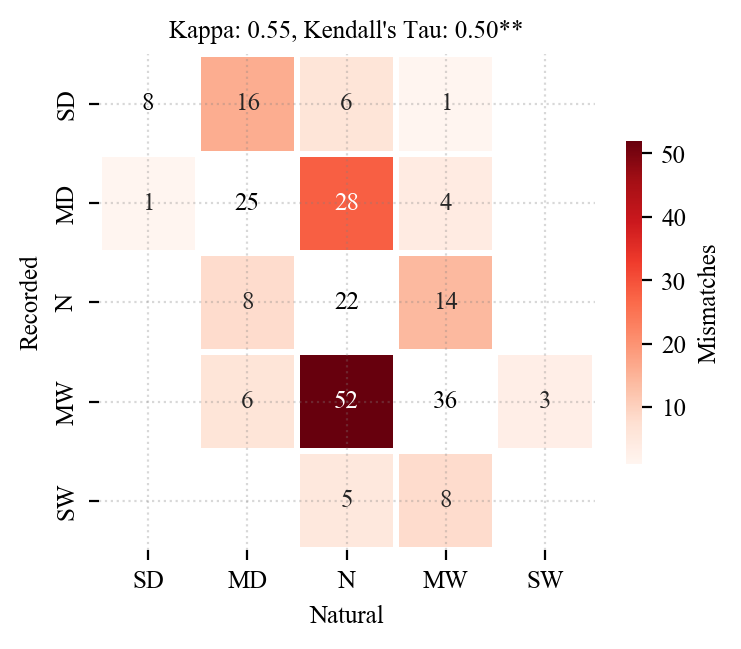

In [5]:
from past1000.utils.plot import plot_confusion_matrix
from past1000.calibration import notna_confusion_matrix, mismatch_stats, dropna_series
from past1000.filters import classify
import matplotlib.pyplot as plt

from past1000.data import HistoricalRecords
from mksci_font import config_font
from past1000.constants import END, LEVELS, STAGE1, TICK_LABELS

config_font({"font.size": 9})
palette = plt.get_cmap("coolwarm").reversed()

# 读取历史数据
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)
history.to_series(
    inplace=True,
    interpolate=None,
    name="historical_mean",
    how="mode",
)

# 获取历史数据和自然数据
SLICE = slice(STAGE1, END)
HISTORICAL_RECORDS = history.data.loc[SLICE]
NATURAL_RECORDS = combined["mean"].loc[SLICE]

# 处理缺失值
natural, historical = dropna_series(
    classify(NATURAL_RECORDS),
    HISTORICAL_RECORDS,
)

# 计算混淆矩阵
cm_df = notna_confusion_matrix(
    y_true=natural,
    y_pred=historical,
    labels=TICK_LABELS,
)

# 计算不匹配情况
title = mismatch_stats(
    y_true=natural,
    y_pred=historical,
    as_str=True,
)

# 绘制混淆矩阵
plot_confusion_matrix(cm_df=cm_df, title=title);

我要找的应该是 last 列应该是和这一次 classified 的等级一样的、上一次的 expect

## 蒙特卡洛分析

对比随机模式的测不准情况会怎么样？

  0%|          | 0/100 [00:00<?, ?it/s]

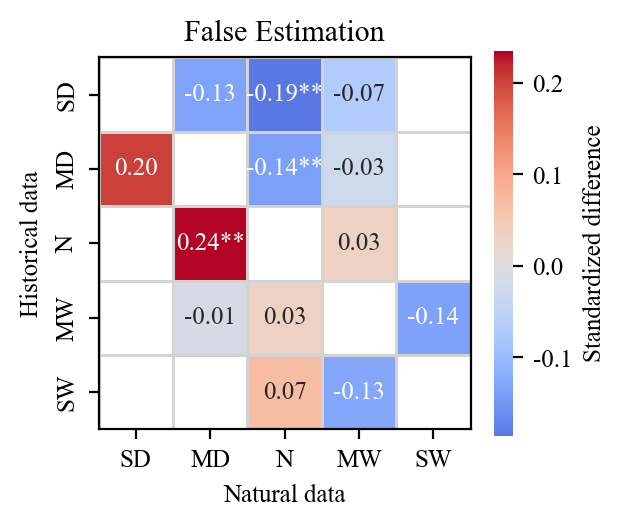

In [6]:
from past1000.calibration import analyze_mismatch

actual_diff, df_p, df_false = analyze_mismatch(
    natural_data=NATURAL_RECORDS,
    historical_data=HISTORICAL_RECORDS,
    cm_df=cm_df,
    plot="heatmap",
)

<Axes: xlabel='Recorded level diff.'>

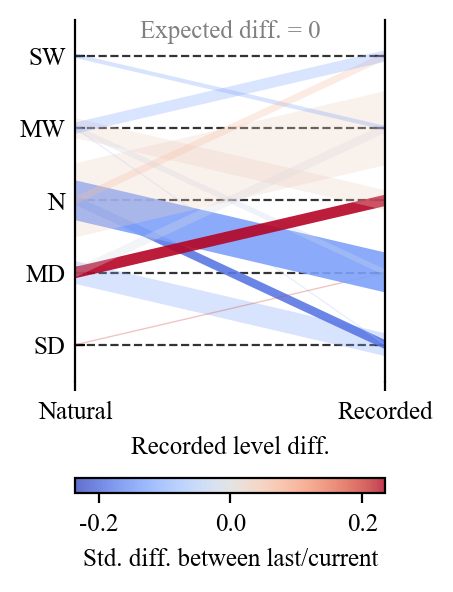

In [7]:
from matplotlib import pyplot as plt
from past1000.utils.plot import plot_mismatch_matrix


plot_mismatch_matrix(
    actual_diff_aligned=actual_diff,
    p_value_matrix=df_p,
    false_count_matrix=df_false,
)
plt.show()

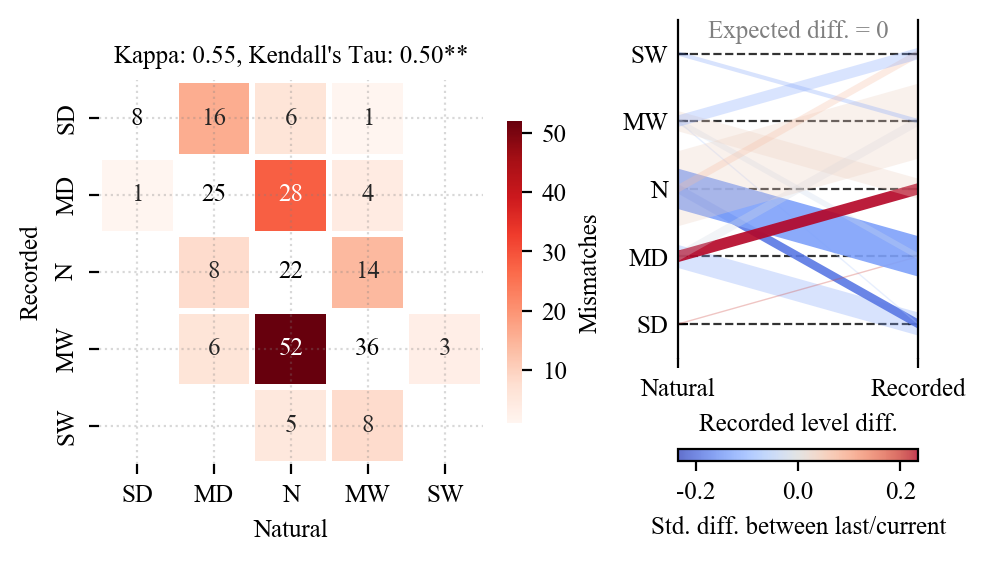

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(5, 3),
    gridspec_kw={"width_ratios": [2, 1]},
    tight_layout=True,
)

## 图1：混淆矩阵
plot_confusion_matrix(cm_df=cm_df, title=title, ax=ax1)

## 图2：热力图
plot_mismatch_matrix(actual_diff, df_p, df_false, ax=ax2)
plt.tight_layout(rect=[0, 0, 1, 1])  # 调整布局以适应标题和图例
plt.show();

Figure 1. a: confusion matrix, showing the number of matched (diagonal, white colour) and mismatched (off-diagonal, red colour) judgments of extreme events between natural and recorded levels. b: mismatched between natural and recorded levels. The colour represents the standardised difference between natural and recorded levels. The line width represents the number of mismatches. The line colour represents the standardised difference between this judgement and the previous judgement at the same level. The line transparency represents the significance of the standardised difference (p < 0.05).